# Kennedy and O'Hagan (KOH) Bayesian Model Calibration Example

이 노트북은 Kennedy and O'Hagan (2001)의 Bayesian Model Calibration 프레임워크를 PyMC를 사용하여 구현한 예제입니다. 컴퓨터 시뮬레이션과 실제 관측 데이터를 결합하여 물리적 파라미터를 추정하고, 모델의 불완전성을 고려한 바이어스 텀을 포함합니다.

## Kennedy and O’Hagan (KOH) 의 Bayesian Model Calibration

KOH framework는 실제 측정된 데이터의 값 z를 다음과 같이 모델링합니다.

$$
z = \rho \ \eta(x, t) + \delta(x) + e
$$

* $\eta(x, t)$ 는 컴퓨터 시뮬레이션 코드의 함수이며 $x$는 함수의 인자, $t$는 함수의 파라미터로 해석할 수 있습니다.  
* $\delta(x)$는 컴퓨터 시뮬레이터와 실제 물리 프로세스 사이의 차이를 나타냅니다.
* $e$는 관측 에러로 시뮬레이터 에러와 관측 에러를 모두 포함합니다.

$\eta(x, t)$와 $\delta(x)$는 Gaussian Process의 형태로 가정됩니다.

컴퓨터 시뮬레이션 코드의 데이터는 미리 지정된 $(y_i, x_i, t_i)$로 주어지며 관측된 물리 프로세스의 데이터는 $(z_i, x_i, \theta)$ 로 주어집니다.   
여기서 $y_i$는 시뮬레이션 코드의 아웃풋을 나타내며 관측된 $\theta$는 물리 프로세스에 가장 적합한 모델 파라미터값 입니다.  
$\theta$값은 알 수 없기 때문에 이 역시 MCMC 샘플링의 대상입니다.

2개의 observed data가 설정되며 각각 다음과 같습니다
$$

\begin{align}
y_i &\sim N(f_{c,i}, \sigma_c^2) \\
f_{c,i} &\sim \text{GP for } \eta
\end{align}
$$

$$
\begin{align}
z_i &\sim N(f_{p,i}, \sigma^2) \\
f_{p,i} &\sim \text{GP for } \eta + \text{GP for } \delta
\end{align}
$$

모든 관측 에러는 노말 분포로 가정되었으며 따라서 전체 관측에러인 컴퓨터 에러, 실험 관측에러의 합은 여전히 노말 분포로 표현할 수 있습니다.

## 1. 라이브러리 임포트 및 환경 설정

이 섹션에서는 Bayesian 추론과 Gaussian Process 모델링에 필요한 핵심 라이브러리들을 임포트합니다. 각 라이브러리의 역할과 사용 목적을 명확히 이해하는 것이 중요합니다.

In [1]:
# 이 예제에서 사용되는 주요 라이브러리들입니다:

# 핵심 라이브러리
# - pymc: Bayesian 통계 모델링과 MCMC (Markov Chain Monte Carlo) 추론을 위한 메인 라이브러리
# - numpy: 수치 연산과 다차원 배열 처리

# 데이터 처리 및 분석
# - arviz: Bayesian 분석 결과의 요약 및 시각화
# - pandas: 표 형식 데이터의 입출력 및 분석

# 시각화
# - matplotlib.pyplot: 2D 데이터 시각화

# 저수준 연산 지원
# - pytensor.tensor: 텐서 연산 지원 (PyMC 내부 연산에 사용)

import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

## 2. 데이터 임포트 및 탐색적 분석

이 섹션에서는 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 로드하고 기본적인 탐색적 분석을 수행합니다. 데이터의 구조와 특성을 이해하는 것이 올바른 모델링의 첫 단계입니다.

In [2]:
# 데이터 파일 로드
# c는 computed (계산된 시뮬레이션 데이터), f는 field (실제 관측된 물리적 프로세스 데이터)를 의미합니다.
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")  # 컴퓨터 시뮬레이션 데이터
df_f = pd.read_csv("../dataset/datafield_hourly.csv")  # 실제 관측 데이터

In [3]:
# 컴퓨터 시뮬레이션 데이터 구조 설명
# - yc: 에너지 사용량 (시뮬레이션 출력값)
# - xc1: 외기온도 (첫 번째 입력 변수)
# - xc2: 상대습도 (두 번째 입력 변수)
# - tc1: 추론하고자 하는 파라미터1 (기기밀도)
# - tc2: 추론하고자 하는 파라미터2 (조명밀도)
# - tc3: 추론하고자 하는 파라미터3 (COP - Coefficient of Performance)

print("컴퓨터 시뮬레이션 데이터 구조:")
df_c

컴퓨터 시뮬레이션 데이터 구조:


,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [4]:
# 실제 관측 데이터 구조 설명
# - yf: 에너지 사용량 (실제 측정값)
# - xf1: 외기온도 (첫 번째 입력 변수)
# - xf2: 상대습도 (두 번째 입력 변수)
# 주의: 실제 데이터에는 추정하고자 하는 파라미터(tc1, tc2, tc3)가 없습니다.
# 이 파라미터들이 우리가 Bayesian 추론을 통해 찾고자 하는 미지수입니다.

print("실제 관측 데이터 구조:")
df_f

실제 관측 데이터 구조:


,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 및 탐색적 분석

데이터의 공간적 분포와 패턴을 이해하기 위해 시각화를 수행합니다. 이를 통해 데이터의 특성과 잠재적인 관계를 파악할 수 있습니다. 

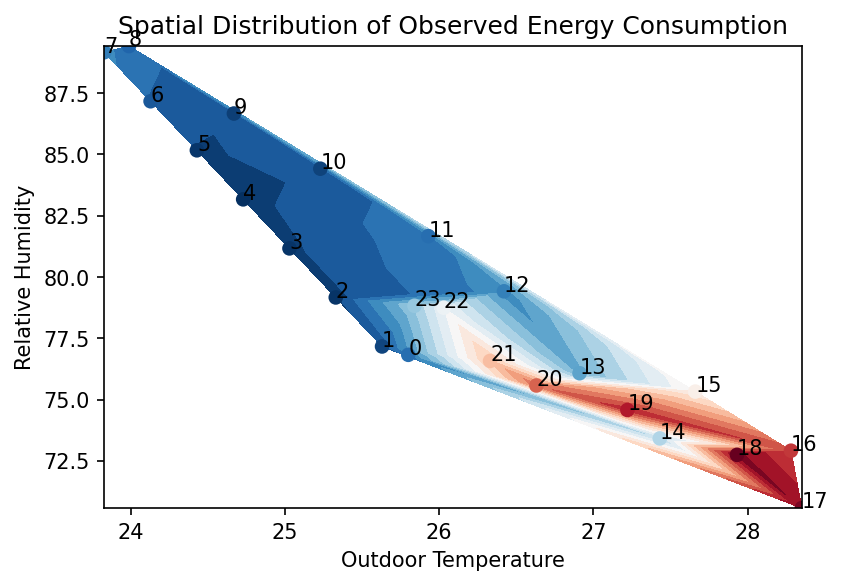

In [5]:
# 실제 물리 프로세스 데이터(df_f)의 2차원 공간 분포를 시각화
# df_f 구조: [zf, xf1, xf2] - 실제 측정값과 2차원 공간 좌표

# 고해상도 플롯 설정 (6x4 인치, 150 DPI)
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 삼각분할 등고선 플롯 (filled contour)
# df_f.iloc[:, 1]: x1 좌표 (공간의 첫 번째 차원), 건구온도
# df_f.iloc[:, 2]: x2 좌표 (공간의 두 번째 차원), 상대습도  
# df_f.iloc[:, 0]: zf 값 (실제 측정값, 등고선의 높이로 표현)
# levels=20: 20개의 등고선 레벨로 세밀한 분포 표현
# cmap="RdBu_r": 빨강-파랑 색상 맵 (역순, 높은 값이 파란색)
ax.tricontourf(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    df_f.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)

# 실제 데이터 포인트들을 산점도로 표시
# 각 점의 색상은 해당 위치의 측정값(zf)에 따라 결정
ax.scatter(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    c=df_f.iloc[:, 0],
    cmap="RdBu_r"
)

# 각 데이터 포인트에 인덱스 번호를 텍스트로 표시
for i in range(df_f.shape[0]):
    ax.text(
        df_f.iloc[i, 1],  # x1 좌표
        df_f.iloc[i, 2],  # x2 좌표
        str(i),           # 포인트 인덱스 번호
        color="black"     # 검은색 텍스트
    )

# 축 레이블과 제목 설정
ax.set_xlabel("Outdoor Temperature")
ax.set_ylabel("Relative Humidity")
ax.set_title("Spatial Distribution of Observed Energy Consumption")

plt.show()

## 4. Bayesian Inference 모델 정의

이 섹션에서는 PyMC를 사용하여 Kennedy and O'Hagan 프레임워크 기반 Bayesian 모델을 정의합니다. 모델은 컴퓨터 시뮬레이션 데이터와 실제 관측 데이터를 통합하여 물리적 파라미터와 모델 불일치 함수를 함께 추정합니다.

### 4-1. 데이터 탐색 및 통계 요약

모델 정의 전에 데이터의 기본 통계량을 확인하여 데이터의 특성과 분포를 이해합니다.

In [6]:
# 컴퓨터 시뮬레이션 데이터의 기본 통계량 확인
# 데이터의 분포, 범위, 중심 경향 등을 파악하여 적절한 사전 분포 설정에 활용
print("컴퓨터 시뮬레이션 데이터 통계 요약:")
df_c.describe()

컴퓨터 시뮬레이션 데이터 통계 요약:


,yc,xc1,xc2,tc1,tc2,tc3
count,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000
mean,238.212208,25.98625,79.417500,8.001000,6.422000,2.916000
std,153.872389,1.33510,5.316637,0.919768,0.734154,0.337964
min,81.710000,23.82000,70.580000,6.630000,5.370000,2.430000
25%,111.735000,24.95500,75.517500,7.100000,5.720000,2.610000
50%,161.390000,25.88000,78.790000,8.015000,6.360000,2.905000
75%,355.855000,26.98750,83.482500,8.670000,7.170000,3.240000
max,590.090000,28.35000,89.420000,9.340000,7.650000,3.450000


In [7]:
# 실제(측정) 데이터의 기초 통계량을 확인하여 분포와 특성 파악에 활용
print("실제(측정) 데이터 통계 요약:")
df_f.describe()

실제(측정) 데이터 통계 요약:


,yf,xf1,xf2
count,24.000000,24.000000,24.00000
mean,237.079167,25.990000,79.41750
std,154.280131,1.359767,5.41966
min,90.930000,23.830000,70.58000
25%,108.802500,24.955000,75.51750
50%,160.140000,25.885000,78.79000
75%,339.160000,26.987500,83.48250
max,533.400000,28.350000,89.42000


### 4-2. 데이터 정규화 (Data Normalization)

Bayesian 추론과 Gaussian Process 모델링에서 데이터 정규화는 수치적 안정성과 수렴성을 위해 필수적입니다.


In [ ]:
# 데이터 정규화 (Min-Max Scaling)
# 모든 데이터를 [0, 1] 범위로 정규화하여 Gaussian Process 모델링의 수치적 안정성을 확보합니다.

print("=== 컴퓨터 시뮬레이션 데이터 정규화 ===")

# 1. 시뮬레이션 출력값 (y) 정규화
# df_c.iloc[:, 0]: 시뮬레이션 코드의 출력값들
y = df_c.iloc[:, 0].values
y_min = y.min()  # 최솟값 저장 (나중에 역변환용)
y_max = y.max()  # 최댓값 저장 (나중에 역변환용)
y = (y - y_min) / (y_max - y_min)  # Min-Max 정규화: (값 - 최솟값) / (최댓값 - 최솟값)
print(f"y 정규화: 원본 범위 [{y_min:.2f}, {y_max:.2f}] → 정규화 범위 [0, 1]")

# 2. 시뮬레이션 입력 변수 (x_c) 정규화  
# df_c.iloc[:, 1:3]: 공간 좌표 (x1, x2)
x_c = df_c.iloc[:, 1:3].values
x_c_min = x_c.min(axis=0)  # 각 차원별 최솟값
x_c_max = x_c.max(axis=0)  # 각 차원별 최댓값
x_c = (x_c - x_c_min) / (x_c_max - x_c_min)  # 차원별로 Min-Max 정규화
print("x_c 정규화: 각 차원별로 [0, 1] 범위로 변환")

# 3. 시뮬레이션 추가 입력 파라미터, 추정 파라미터 (theta) 정규화
# df_c.iloc[:, 3:]: 모델 추정 파라미터 (theta1, theta2, theta3)
# 주의: 변수명을 t_c에서 theta로 변경 (최신 버전과 일치)
theta = df_c.iloc[:, 3:].values
theta_min = 0  # 하한선을 0으로 고정 (양수 파라미터)
theta_max = theta.max(axis=0)  # 각 파라미터별 최댓값 (정규화에 사용)
theta = (theta - theta_min) / (theta_max - theta_min)  # [0, 최댓값] → [0, 1] 범위로 정규화
print(f"theta 정규화: [0, {theta_max}] → [0, 1] 범위로 변환")

print(f"정규화된 데이터 크기: {y.shape = }, {x_c.shape = }, {theta.shape = }")

# 4. 실제 관측 데이터 정규화
# 위에서 사용된 정규화 파라미터를 실험 데이터 정규화에도 그대로 적용합니다.
# 이를 통해 관측 데이터와 시뮬레이션 데이터가 같은 스케일에서 비교 가능합니다.
z = df_f.iloc[:, 0].values
z = (z - y_min) / (y_max - y_min)  # y의 정규화 파라미터 사용
print(f"z 정규화: y와 동일한 스케일 적용 [{y_min = :.2f}, {y_max = :.2f}] → [0, 1]")

# 5. 실제 관측 좌표 (x_p) 정규화
# 시뮬레이션 좌표와 같은 스케일을 적용
x_p = df_f.iloc[:, 1:3].values
x_p = (x_p - x_c_min) / (x_c_max - x_c_min)  # x_c의 정규화 파라미터 사용
print("x_p 정규화: x_c와 동일한 스케일 적용")

print(f"정규화된 데이터 크기: {z.shape = }, {x_p.shape = }")

=== 컴퓨터 시뮬레이션 데이터 정규화 ===
y 정규화: 원본 범위 [81.71, 590.09] → 정규화 범위 [0, 1]
x_c 정규화: 각 차원별로 [0, 1] 범위로 변환
theta 정규화: [0, [9.34 7.65 3.45]] → [0, 1] 범위로 변환
정규화된 데이터 크기: y.shape = (240,), x_c.shape = (240, 2), theta.shape = (240, 3)
z 정규화: y와 동일한 스케일 적용 [y_min = 81.71, y_max = 590.09] → [0, 1]
x_p 정규화: x_c와 동일한 스케일 적용
정규화된 데이터 크기: z.shape = (24,), x_p.shape = (24, 2)


### 4-3. PyMC 모델 정의 및 구조

이 섹션에서는 Kennedy and O'Hagan 프레임워크에 따라 두 개의 Gaussian Process를 사용하여 모델을 정의합니다:
1. **$\eta$ GP**: 컴퓨터 시뮬레이션 함수 에뮬레이터 (5차원 입력: $x_1, x_2, \theta_1, \theta_2, \theta_3$)
2. **$\delta$ GP**: 모델 불일치 함수 (2차원 입력: $x_1, x_2$)

In [ ]:
# 물리적 파라미터 theta_true의 사전 분포 범위 정의
# 원래 물리적 단위의 최대값([10, 10, 5])을 정규화된 스케일로 변환
# theta_max는 위에서 정규화에 사용된 최댓값
theta_max_prior = np.array([10, 10, 5]) / theta_max
theta_max_prior

array([1.07066381, 1.30718954, 1.44927536])

In [10]:
with pm.Model() as koh_model:
    # ============================================================
    # 1. 컴퓨터 모델 에뮬레이터 GP (eta) 정의
    # ============================================================
    # eta GP는 5차원 입력 공간 (x1, x2, theta1, theta2, theta3)에서 동작
    # 이를 통해 시뮬레이션 함수 eta(x, theta)를 에뮬레이트
    
    # Length-scale 파라미터: 각 입력 차원에서의 함수 변동성 특성을 제어
    # Gamma 분포 사용 이유: 양수만 허용 (분모에 사용되므로 0이면 안됨)
    # shape=5: 5개 입력 차원 (x1, x2, theta1, theta2, theta3) 각각에 대한 독립적인 length-scale
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=5)

    # Amplitude 파라미터: GP 함수 값의 전체적인 변동 폭을 결정
    # HalfCauchy 분포 사용 이유: 0을 포함한 양수 허용, heavy-tail로 유연한 사전 분포
    eta_eta = pm.HalfCauchy("eta_eta", beta=1)

    # 커널 함수 정의: Exponential Quadratic (RBF) 커널
    # k(x_i, x_j) = eta^2 * exp(-0.5 * sum((x_i - x_j)^2 / ls^2))
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls_eta)
    
    # Latent GP 정의: eta 함수를 직접 모델링
    # Latent GP를 사용하는 이유: 두 개의 GP(eta, delta)를 결합해야 하므로
    gp_eta = pm.gp.Latent(cov_func=cov_eta)

    # ============================================================
    # 2. 모델 불일치 함수 GP (delta) 정의
    # ============================================================
    # delta GP는 2차원 입력 공간 (x1, x2)에서 동작
    # 이를 통해 시뮬레이터와 실제 물리 프로세스 사이의 체계적 차이를 모델링
    
    # Length-scale 파라미터: 공간 변수(x1, x2)에 대한 함수 변동성
    # shape=2: 2개 입력 차원 (x1, x2) 각각에 대한 독립적인 length-scale
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5, shape=2)
    
    # Amplitude 파라미터: 모델 불일치 함수의 변동 폭
    eta_delta = pm.HalfCauchy("eta_delta", beta=1)
    
    # 커널 함수 정의: Exponential Quadratic (RBF) 커널
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_delta)
    
    # Latent GP 정의: delta 함수를 직접 모델링
    gp_delta = pm.gp.Latent(cov_func=cov_delta)

    # ============================================================
    # 3. 시뮬레이션 데이터 입력 구성
    # ============================================================
    # 시뮬레이션 데이터의 입력: 공간 좌표(x_c)와 파라미터(theta) 결합
    # theta는 시뮬레이션에 사용된 다양한 파라미터 값들
    X_c = np.hstack([x_c, theta])  # (n_sim, 5) 형태: (x1, x2, theta1, theta2, theta3)

    # ============================================================
    # 4. 물리적 파라미터 추정을 위한 사전 분포 정의
    # ============================================================
    # theta_true: 추정하고자 하는 미지의 물리적 파라미터 (theta1, theta2, theta3)
    # Uniform 분포 사용 이유: 
    #   - 파라미터가 음수가 될 수 없는 물리적 제약
    #   - theta_max_prior까지의 범위에서 균등 분포로 약한 정보 제공
    #   - 변수명을 theta에서 theta_true로 변경하여 시뮬레이션 파라미터(theta)와 구분
    theta_true = pm.Uniform("theta_true", lower=0, upper=theta_max_prior, shape=3)

    # ============================================================
    # 5. 실제 관측 데이터 입력 구성
    # ============================================================
    # 모든 관측치가 동일한 물리 시스템(동일한 theta_true)에서 나왔다고 가정
    # pt.tile을 사용하여 theta_true를 관측치 개수만큼 복제
    X_p = pt.concatenate([x_p, pt.tile(theta_true, (x_p.shape[0], 1))], axis=1)  # (n_obs, 5)

    # ============================================================
    # 6. 전체 입력 데이터 통합
    # ============================================================
    # 시뮬레이션과 실제 관측 데이터를 수직으로 결합하여 하나의 eta GP로 모델링
    # 이를 통해 시뮬레이션 정보가 theta_true 추정에 활용됨
    X_all = pt.concatenate([X_c, X_p], axis=0)  # (n_sim + n_obs, 5)

    # eta GP의 prior 함수값 계산: 모든 입력점(시뮬레이션 + 관측)에서의 함수값
    f_c = gp_eta.prior("f_c", X=X_all)

    # ============================================================
    # 7. 시뮬레이션 관측 모델 정의
    # ============================================================
    # 컴퓨터 시뮬레이션 노이즈 정의
    # sigma_c: 시뮬레이션 과정에서 발생하는 랜덤 노이즈의 표준편차
    # HalfNormal 분포 사용 이유: 양수 제약, 데이터 정규화로 인해 작은 값(0.01) 사용
    sigma_c = pm.HalfNormal("sigma_c", sigma=0.01)

    # 시뮬레이션 관측 데이터 정의
    # f_c[:len(y)]: 시뮬레이션 입력점들에서의 eta 함수값
    y_obs = pm.Normal("y_obs", mu=f_c[:len(y)], sigma=sigma_c, observed=y)

    # ============================================================
    # 8. 실제 관측 모델 정의 (KOH 프레임워크)
    # ============================================================
    # 실제 물리 프로세스는 eta + delta로 모델링됨
    
    # f_p_eta: 실제 관측 입력점들에서의 eta 함수값
    # f_c[len(y):]는 관측 입력점들에서의 eta 함수값을 포함
    f_p_eta = pm.Deterministic("f_p_eta", f_c[len(y):])
    
    # f_p_delta: 모델 불일치 함수값 (2차원 입력 x_p만 사용)
    f_p_delta = gp_delta.prior("f_p_delta", X=x_p)

    # f_p: 실제 물리 프로세스 함수값 = eta + delta
    f_p = pm.Deterministic("f_p", f_p_eta + f_p_delta)

    # 실제 관측 노이즈 정의
    # sigma: 시뮬레이션 노이즈(sigma_c)와 추가 관측 노이즈(sigma_p)의 합
    # 이는 실제 관측 과정에서 발생하는 전체 노이즈를 나타냄
    sigma = pm.Deterministic("sigma", sigma_c + pm.HalfNormal("sigma_p", sigma=0.01))

    # 실제 관측 데이터 정의
    # z_obs: 실제 측정값은 f_p (eta + delta)에 노이즈가 더해진 형태
    z_obs = pm.Normal("z_obs", mu=f_p, sigma=sigma, observed=z)

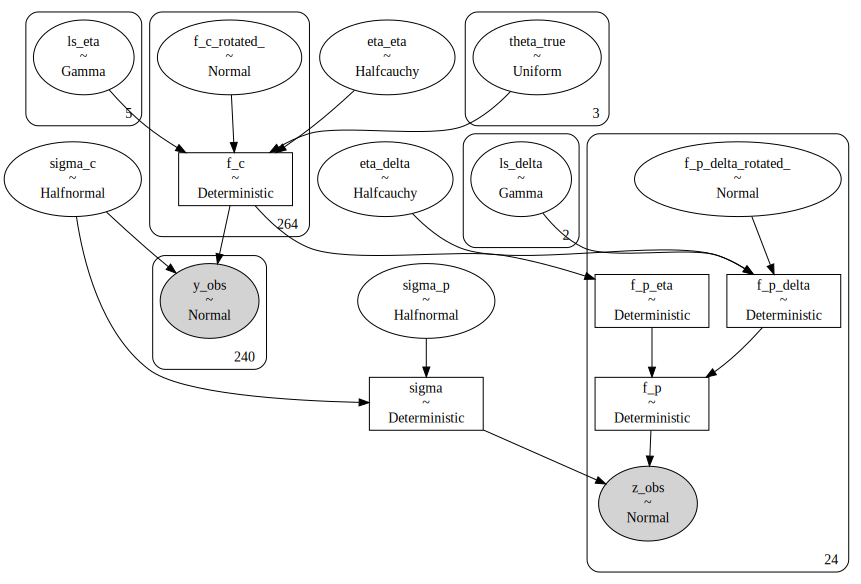

In [11]:
pm.model_to_graphviz(koh_model)

## 5. MCMC 샘플링 수행

이 섹션에서는 NUTS (No-U-Turn Sampler)를 사용하여 사후 분포에서 샘플링을 수행합니다. MCMC를 통해 미지의 파라미터 theta_true, 모델 불일치 함수 delta, 그리고 하이퍼파라미터들의 사후 분포를 근사합니다.

In [12]:
with koh_model:
    # MCMC 샘플링 실행
    # NUTS (No-U-Turn Sampler): Hamiltonian Monte Carlo의 개선된 버전
    trace = pm.sample(
        draws=1000,              # 샘플링할 체인 길이 (실제 샘플 개수)
        tune=1000,               # 워밍업/버닝 단계 길이 (샘플러 파라미터 튜닝)
        chains=1,                # 샘플링할 체인 수 (수렴성 진단을 위해 보통 4개 권장)
        cores=1,                 # 병렬 처리에 사용할 CPU 코어 수
        nuts_sampler="numpyro",  # NumPyro 백엔드 사용 (빠른 성능과 GPU 지원)
        target_accept=0.95,      # 목표 수락률 (높을수록 보수적이고 안정적)
        random_seed=42,
    )

/home/wonjun/Codes/pymc-examples/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
sample: 100%|██████████| 2000/2000 [1:45:24<00:00,  3.16s/it, 1023 steps of size 7.95e-04. acc. prob=0.91]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


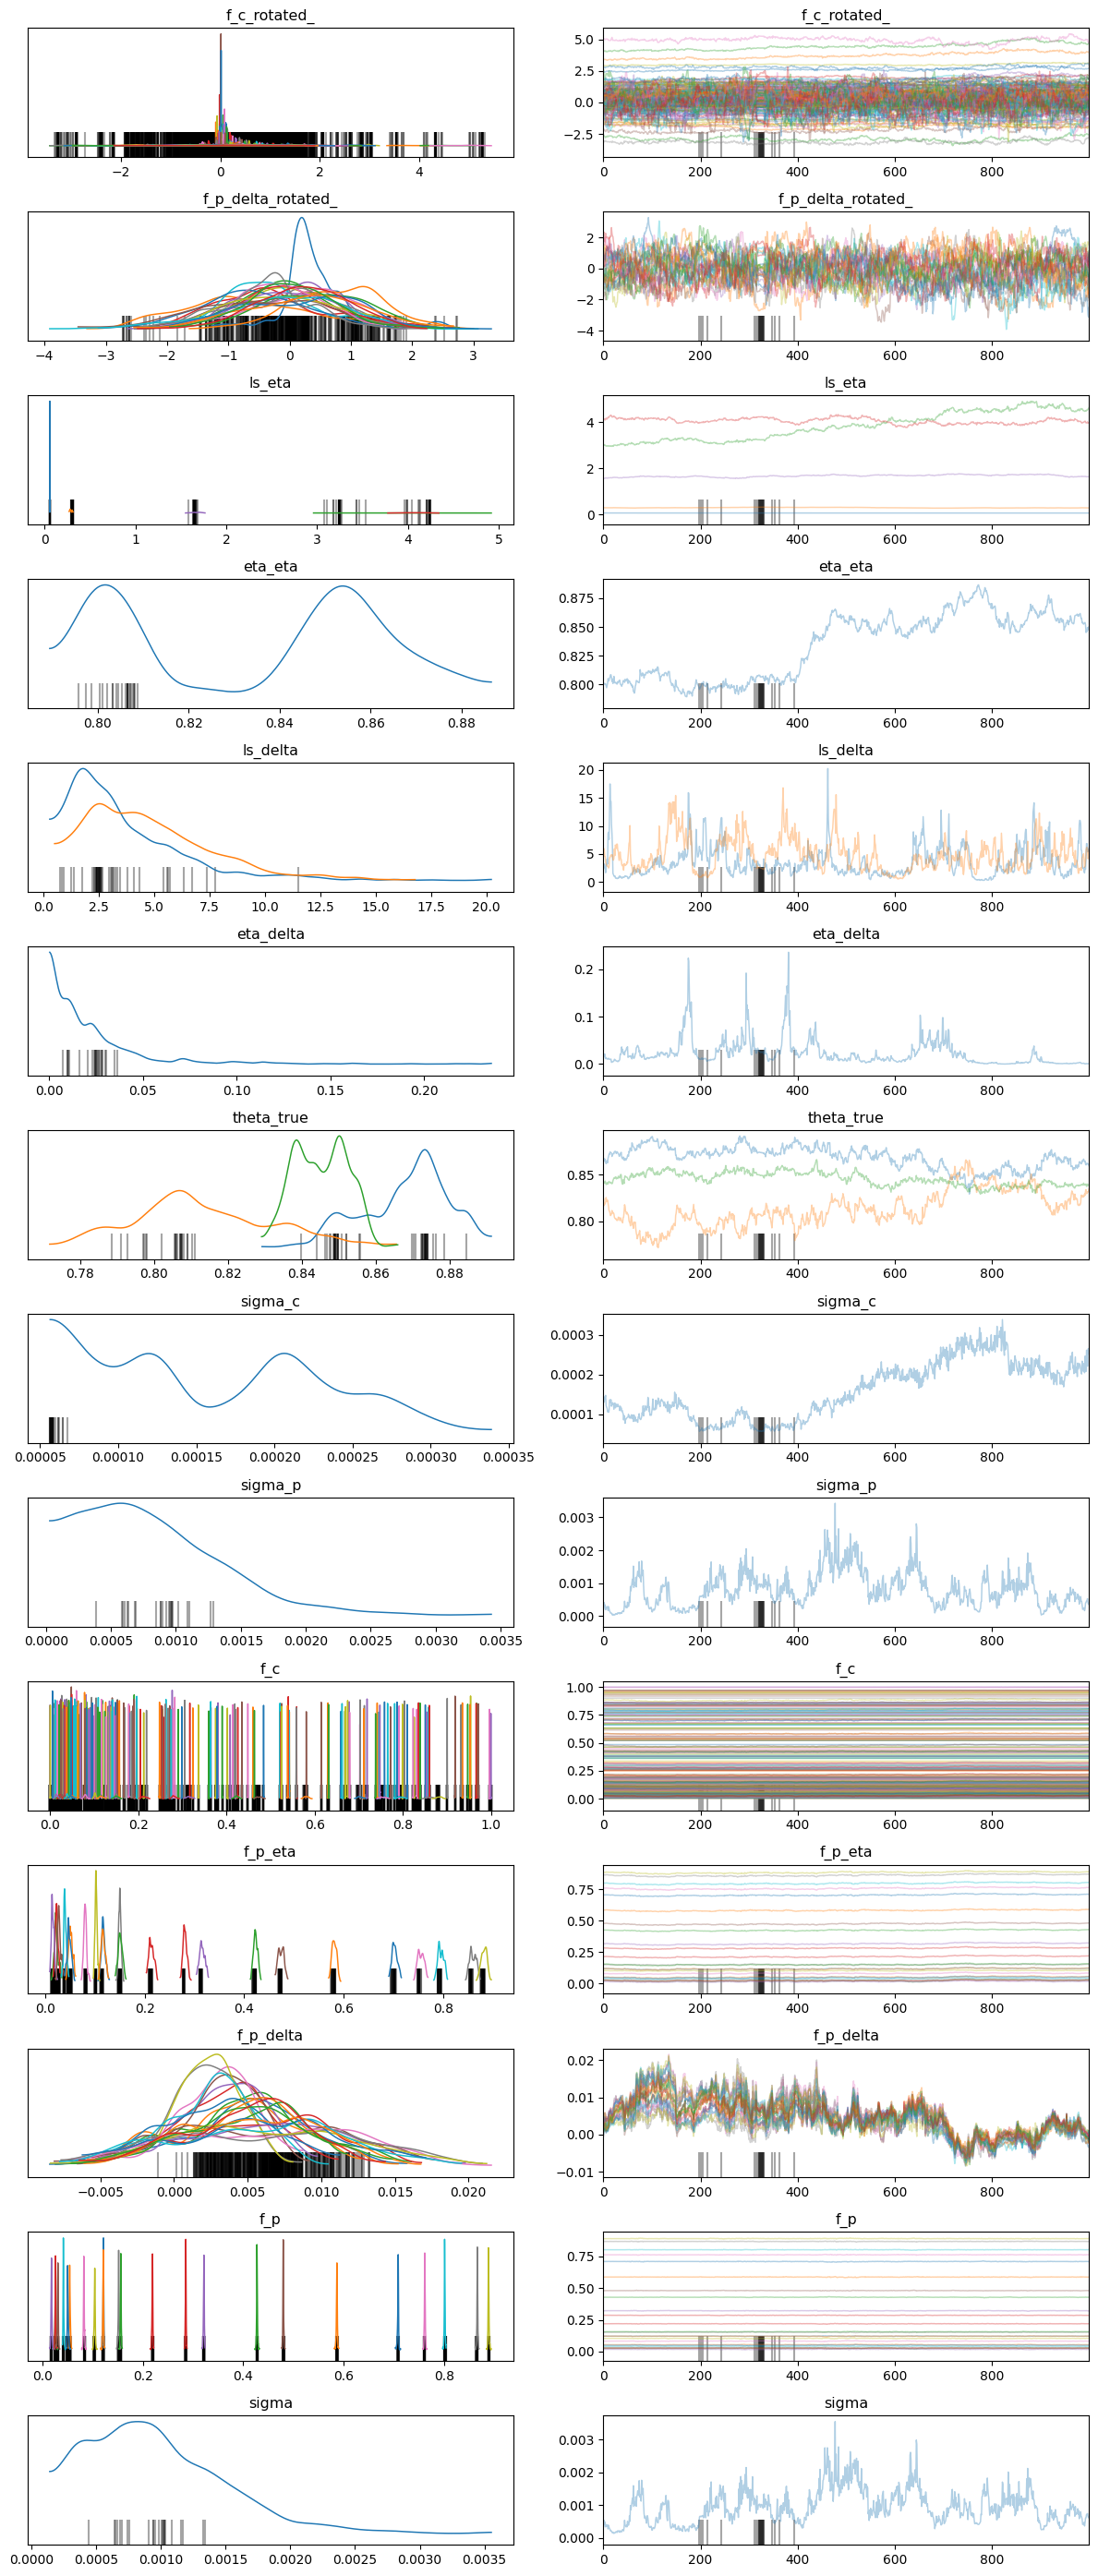

In [17]:
# 사후 분포 trace 플롯 생성
# 왼쪽 열: 각 파라미터의 사후 분포 히스토그램
# 오른쪽 열: MCMC 샘플링 과정에서의 파라미터 값 변화 (수렴성 진단)
az.plot_trace(trace, legend=False)
plt.tight_layout()
plt.show()

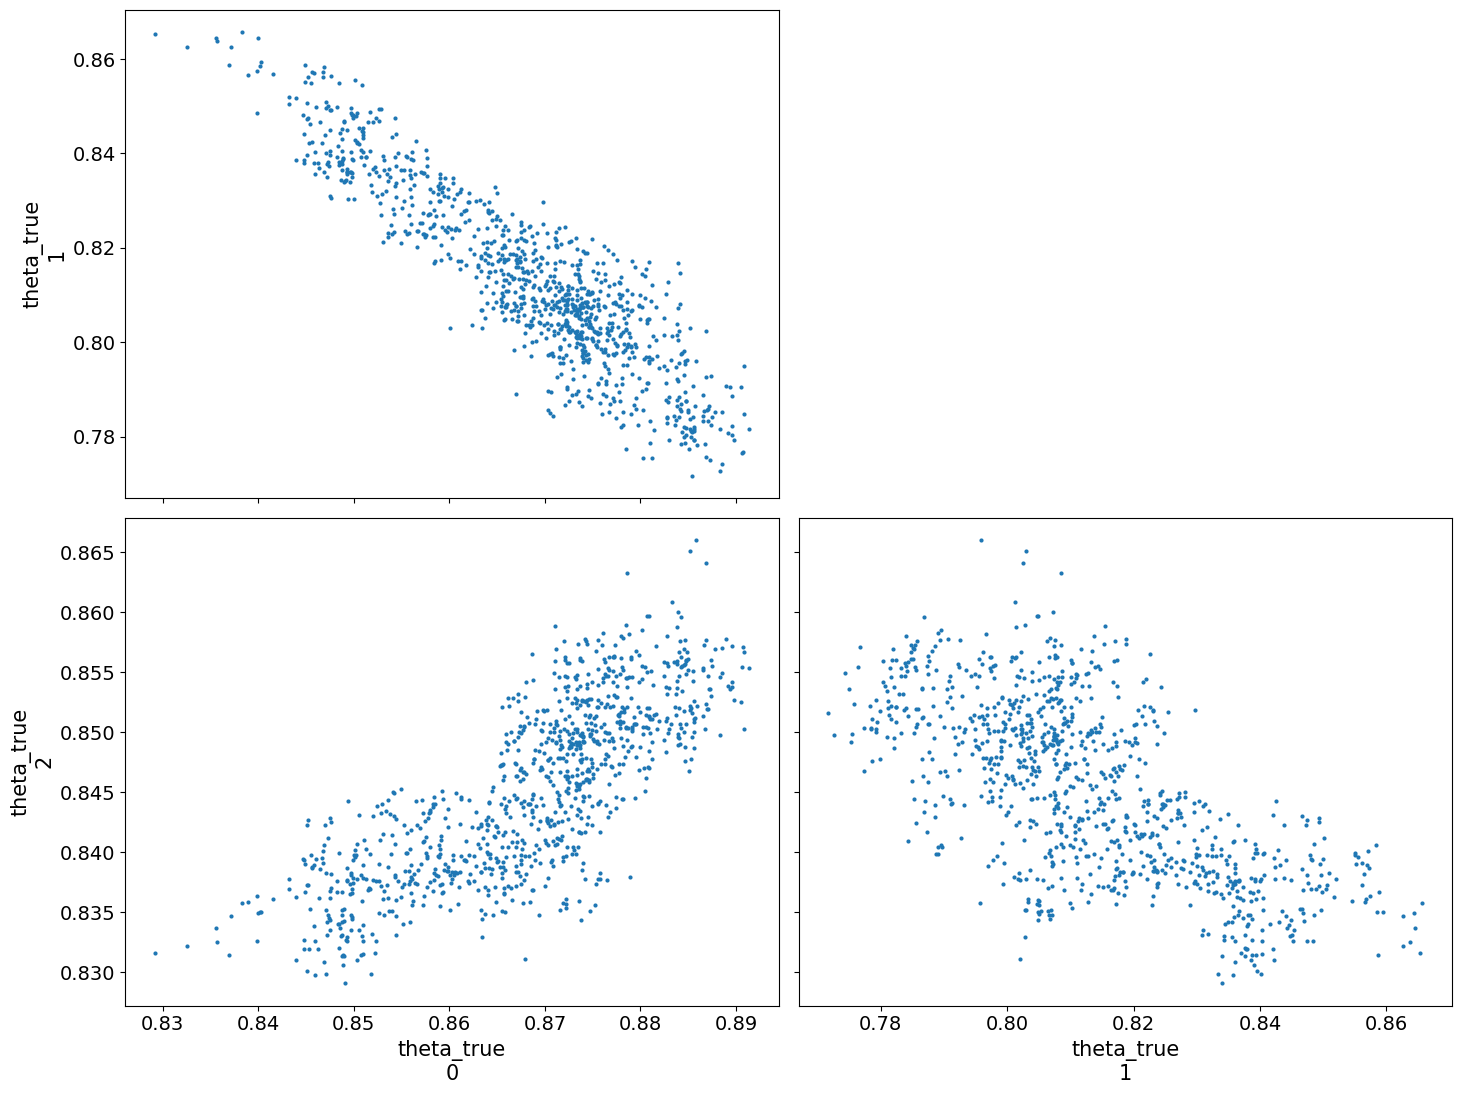

In [18]:
# theta_true 파라미터 간의 상관관계 시각화
# 대각선: 각 파라미터의 주변 분포 (marginal distribution)
# 비대각선: 파라미터 쌍 간의 결합 분포 (joint distribution)
# 이를 통해 파라미터 간의 상관성과 불확실성 구조 파악
# 주의: 변수명을 theta에서 theta_true로 변경
az.plot_pair(trace, var_names=["theta_true"])
plt.tight_layout()
plt.show()

## 원래 차원으로 복원하여 함수 파라미터 시각화

### 역변환의 필요성

MCMC 샘플링을 통해 얻은 `theta_true` 파라미터들은 **정규화된 [0, 1] 범위**에 있습니다. 하지만 실제 물리적 해석과 비교를 위해서는 **원래의 물리적 단위**로 복원해야 합니다.

### 역변환 과정

#### **1. 정규화 파라미터 복원**
```python
trace_ = trace.copy()
trace_.posterior.theta_true.values *= theta_max[None, None, :]
```

**수학적 표현**:
$$\theta_{true,\text{original}} = \theta_{true,\text{normalized}} \times \theta_{\text{max}}$$

여기서:
- $\theta_{true,\text{normalized}}$: MCMC로 샘플링된 정규화된 파라미터 [0, 1]
- $\theta_{\text{max}}$: 정규화 시 사용된 최댓값 벡터
- $\theta_{true,\text{original}}$: 원래 물리적 단위의 파라미터

#### **2. 차원 구조 설명**
```python
theta_max[None, None, :]
```

이 표현의 차원 구조:
- `theta_max`: (3,) - 3개 파라미터의 최댓값
- `[None, None, :]`: (1, 1, 3) - 브로드캐스팅을 위한 차원 확장
- `trace.posterior.theta_true`: (1, 1000, 3) - (chain, draw, parameter)
- 결과: (1, 1000, 3) - 모든 샘플에 대해 역변환 적용


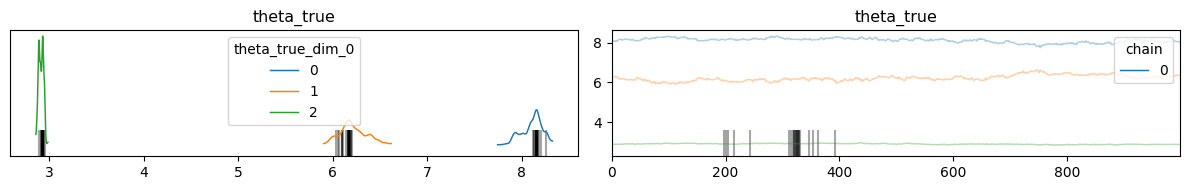

In [21]:

# theta_true 파라미터를 원래 물리적 단위로 역변환
# 정규화된 [0, 1] 범위에서 원래 파라미터 범위로 복원
trace_ = trace.copy()
# theta_max는 위에서 정규화 시 사용된 최댓값
trace_.posterior.theta_true.values *= theta_max[None, None, :]  # 브로드캐스팅으로 모든 샘플에 적용

# 역변환된 theta_true 값들의 사후 분포 시각화
# 이제 물리적 단위로 해석 가능 (기기밀도, 조명밀도, COP)
az.plot_trace(trace_, legend=True, var_names=["theta_true"])
plt.tight_layout()
plt.show()

In [22]:
with koh_model:
    samples = pm.sample_posterior_predictive(
        trace,
        var_names=["y_obs", "z_obs"],
    )

Sampling: [y_obs, z_obs]


Output()

In [23]:
samples.posterior_predictive.y_obs.mean(axis=(0, 1))

<xarray.DataArray 'y_obs' (y_obs_dim_0: 240)> Size: 2kB
array([ 9.23122400e-02,  2.83103008e-02,  6.90219824e-03,  6.81963413e-03,
       -2.27791454e-05,  1.00260393e-02,  5.97428993e-02,  1.31964355e-01,
        8.73354400e-02,  2.54848338e-02,  2.27111184e-02,  7.90807655e-02,
        1.18615854e-01,  1.79056366e-01,  2.77048160e-01,  4.34888290e-01,
        7.02660702e-01,  8.03739887e-01,  8.26085687e-01,  7.45513465e-01,
        6.59859567e-01,  5.42878238e-01,  3.90414642e-01,  2.52317805e-01,
        9.82262163e-02,  2.86874181e-02,  7.54043574e-03,  7.61133321e-03,
        5.07119290e-04,  1.13096619e-02,  5.91362067e-02,  1.26249721e-01,
        8.27419314e-02,  2.38529772e-02,  2.18736162e-02,  9.16072918e-02,
        1.44049999e-01,  2.18782062e-01,  3.36423529e-01,  5.23514531e-01,
        8.37062284e-01,  9.35235814e-01,  9.47393840e-01,  8.35884557e-01,
        7.19093947e-01,  5.81212412e-01,  4.14403257e-01,  2.67984795e-01,
        1.11341622e-01,  5.26024550e-02,  2.77196929e-02,  2.77022504e-02,
        1.90975486e-02,  3.35138087e-02,  8.17447680e-02,  1.41048516e-01,
        9.55642623e-02,  3.88486693e-02,  4.60612439e-02,  1.09354136e-01,
        1.40298920e-01,  1.97319399e-01,  2.90861805e-01,  4.25918309e-01,
        6.78780889e-01,  7.72131243e-01,  7.91829376e-01,  7.12915688e-01,
        6.29746289e-01,  5.21630122e-01,  3.79367655e-01,  2.54688172e-01,
        1.12424468e-01,  4.86127740e-02,  2.22516577e-02,  2.22716894e-02,
        1.45067388e-02,  2.63275567e-02,  7.90738034e-02,  1.53128889e-01,
...
        8.51244507e-01,  9.52787630e-01,  9.67759597e-01,  8.60336659e-01,
        7.48277574e-01,  6.15189000e-01,  4.48739893e-01,  3.05407130e-01,
        1.37999051e-01,  6.12610147e-02,  2.81363140e-02,  2.80995986e-02,
        2.01797684e-02,  3.21552601e-02,  8.77022047e-02,  1.67070898e-01,
        1.16778127e-01,  4.79466721e-02,  6.15150675e-02,  1.40851864e-01,
        1.79179312e-01,  2.48194269e-01,  3.60156065e-01,  5.40533148e-01,
        8.53981824e-01,  9.71792529e-01,  9.96917876e-01,  9.00990778e-01,
        7.99245787e-01,  6.62430900e-01,  4.84415558e-01,  3.23996365e-01,
        1.08362954e-01,  4.87630491e-02,  2.45552308e-02,  2.45607843e-02,
        1.63345098e-02,  2.98139909e-02,  7.87505153e-02,  1.41325737e-01,
        9.56468217e-02,  3.74164251e-02,  4.24707313e-02,  1.03831357e-01,
        1.34704809e-01,  1.90847548e-01,  2.83062610e-01,  4.19098486e-01,
        6.70051545e-01,  7.65628401e-01,  7.87156607e-01,  7.11607279e-01,
        6.31594141e-01,  5.23991821e-01,  3.80975048e-01,  2.54366809e-01,
        1.78494460e-01,  1.04464636e-01,  5.87174476e-02,  5.77723548e-02,
        4.79823557e-02,  6.35612124e-02,  1.24289003e-01,  2.04855010e-01,
        1.48780962e-01,  7.95354052e-02,  1.26395323e-01,  1.84776193e-01,
        2.12420858e-01,  2.74822555e-01,  3.79295683e-01,  5.38827617e-01,
        8.39443200e-01,  9.66518092e-01,  9.99993105e-01,  9.18688775e-01,
        8.31890655e-01,  7.03314927e-01,  5.25173367e-01,  3.64449419e-01])
Coordinates:
  * y_obs_dim_0  (y_obs_dim_0) int64 2kB 0 1 2 3 4 5 ... 234 235 236 237 238 239

In [24]:
y

array([9.22734962e-02, 2.83646092e-02, 6.84527322e-03, 6.84527322e-03,
       0.00000000e+00, 1.00712066e-02, 5.96994374e-02, 1.32007553e-01,
       8.73559149e-02, 2.54730713e-02, 2.27585664e-02, 7.90550376e-02,
       1.18592392e-01, 1.79058972e-01, 2.77076203e-01, 4.34910893e-01,
       7.02663362e-01, 8.03768834e-01, 8.26094654e-01, 7.45564342e-01,
       6.59860734e-01, 5.42861639e-01, 3.90416617e-01, 2.52389945e-01,
       9.83319564e-02, 2.86006531e-02, 7.57307526e-03, 7.57307526e-03,
       5.11428459e-04, 1.12907667e-02, 5.91683386e-02, 1.26263818e-01,
       8.27137181e-02, 2.38601046e-02, 2.18930721e-02, 9.15850348e-02,
       1.44026122e-01, 2.18734018e-01, 3.36421574e-01, 5.23506039e-01,
       8.37090365e-01, 9.35245289e-01, 9.47401550e-01, 8.35910146e-01,
       7.19107754e-01, 5.81238444e-01, 4.14414414e-01, 2.67949172e-01,
       1.11314371e-01, 5.25591093e-02, 2.77154884e-02, 2.77154884e-02,
       1.91392266e-02, 3.34788937e-02, 8.17498721e-02, 1.41036233e-01,
      

In [25]:
samples.posterior_predictive.z_obs.mean(axis=(0, 1))

<xarray.DataArray 'z_obs' (z_obs_dim_0: 24)> Size: 192B
array([0.12177411, 0.05478652, 0.02616295, 0.02621313, 0.01815626,
       0.03076595, 0.08283882, 0.15201904, 0.10421685, 0.04214542,
       0.05080339, 0.1211855 , 0.15616729, 0.21917099, 0.3216885 ,
       0.47988723, 0.76172685, 0.86630027, 0.88871325, 0.80124337,
       0.70837161, 0.58654587, 0.42762863, 0.28561033])
Coordinates:
  * z_obs_dim_0  (z_obs_dim_0) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

array([0.12177898, 0.05434911, 0.02629922, 0.02629922, 0.01813604,
       0.03105944, 0.08273339, 0.15207129, 0.10448877, 0.04193713,
       0.05011999, 0.12148393, 0.15647744, 0.21952083, 0.32204257,
       0.47964121, 0.76167434, 0.86643849, 0.88848893, 0.80113301,
       0.7088005 , 0.58672646, 0.4274165 , 0.28567214])